In [ ]:
# Instalar la versión CORRECTA de OpenCV y luego importar

# Desinstalar primero para evitar conflictos (el -y evita la pregunta de confirmación)
!pip uninstall opencv-python -y
!pip uninstall opencv-contrib-python -y # Asegurarse de quitar ambas si existen

# Instalar la versión que incluye los módulos contrib
!pip install opencv-contrib-python

# --- IMPORTANTE ---
# Después de ejecutar esta celda, DEBES REINICIAR EL ENTORNO DE EJECUCIÓN.
# En Colab: Ve a "Entorno de ejecución" -> "Reiniciar entorno de ejecución..."
# Luego, vuelve a ejecutar todas las celdas desde el principio.
# ------------------

Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (69.1 MB)


# Laboratorio Integrador: Detección de Rostros y Puntos Faciales Clave (Landmarks)

**Objetivo:** En esta práctica integradora, aplicaremos y conectaremos dos técnicas importantes de Visión por Computadora que hemos visto:

1.  **Detección de Rostros:** Utilizaremos el método de Haar Cascades para encontrar la ubicación de múltiples caras dentro de una imagen.
2.  **Detección de Landmarks Faciales:** Una vez localizadas las caras, aplicaremos un modelo más avanzado (LBF) para identificar 68 puntos clave específicos en cada rostro (ojos, cejas, nariz, boca, mandíbula).

**Contexto:** Estas técnicas son fundamentales en muchas aplicaciones, desde filtros de redes sociales y sistemas de reconocimiento facial hasta análisis de expresiones o detección de somnolencia en conductores.

**Imagen de Trabajo:** Usaremos una icónica imagen de la película argentina "Nueve Reinas".

**¡Manos a la obra!**

## Sección 0: Configuración del Entorno

Antes de comenzar, necesitamos asegurarnos de tener las librerías adecuadas y descargar los archivos necesarios (imagen, modelos pre-entrenados).

### 0.1 Instalación e Importación de Librerías

*   **`opencv-python` (`cv2`):** Librería esencial para visión por computadora.
*   **`opencv-contrib-python`:** Contiene módulos extra de OpenCV, incluyendo `cv2.face` que usaremos para los landmarks. A menudo, instalar este paquete reemplaza o incluye `opencv-python`.
*   **`matplotlib.pyplot` (`plt`):** Para visualizar imágenes dentro del cuaderno.
*   **`numpy` (`np`):** Para manejo eficiente de arrays (las imágenes son arrays).

In [ ]:
# Instalar librerías (si es necesario) y luego importar
# Usamos %%capture para ocultar la salida detallada de la instalación.
#%%capture
#!pip uninstall opencv-python -y # Desinstalar versión base si existe
#!pip install matplotlib opencv-contrib-python # Instalar versión con módulos extra

import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Librerías importadas.")

Librerías importadas.


### 0.2 Descarga de Recursos

Descargaremos:

1.  **Imagen:** `9reinas.jpg`.
2.  **Clasificador Haar:** `haarcascade_frontalface_default.xml`. Lo descargaremos directamente del repositorio oficial de OpenCV en GitHub. Este archivo contiene los patrones Haar pre-calculados para detectar rostros frontales.
3.  **Modelo de Landmarks LBF:** `lbfmodel.yaml`. Este es un modelo pre-entrenado específico para el algoritmo LBF (Local Binary Features) de detección de landmarks. (Usaremos el enlace del cuaderno original, ya que es una fuente común para este archivo específico). *Nota: Este archivo es grande (~70Mb) y puede tardar un poco.*

In [ ]:
# Descargar archivos necesarios

# Descargar clasificador Haar desde el repositorio oficial de OpenCV
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -O haarcascade_frontalface_default.xml
print("Clasificador Haar descargado.")

# Descargar modelo de landmarks LBF (puede tardar)
# Usamos %%capture para ocultar la salida si es muy larga
#%%capture
!wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml -O lbfmodel.yaml
print("Modelo LBF para landmarks descargado.")
print("¡Recursos listos!")

Clasificador Haar descargado.
--2025-05-17 23:00:22--  https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml [following]
--2025-05-17 23:00:23--  https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56375857 (54M) [text/plain]
Saving to: ‘lbfmodel.yaml’

lbfmodel.yaml       100%[===================>]  53.76M   238MB/s    in 0.2s    

2025-05-17 23:00:23 (238 MB/s) - ‘lbfmodel.yaml’ saved [56375857/56375857]



### 0.3 Carga Inicial de la Imagen

Cargamos la imagen descargada usando `cv2.imread`.

In [ ]:
# Cargar la imagen original
from google.colab import files

uploaded = files.upload()

Saving messi-maradona.jfif to messi-maradona (3).jfif


In [ ]:
# Leo la imagen
image = cv2.imread("messi-maradona (3).jfif")

## Sección 1: Detección de Rostros con Haar Cascades

**Concepto:** Las Haar Cascades son un método rápido basado en características visuales simples (diferencias de intensidad en patrones tipo Haar) para detectar objetos, en este caso, rostros. El clasificador (`.xml`) contiene una "cascada" de filtros: la imagen pasa por filtros cada vez más específicos, y si falla en uno temprano, se descarta rápidamente, haciendo el proceso eficiente. Funciona mejor en escala de grises.

### 1.1 **Ejercicio 1:** Convertir la Imagen a RGB

OpenCV carga en BGR. Para mostrar con Matplotlib, la convertimos a RGB.

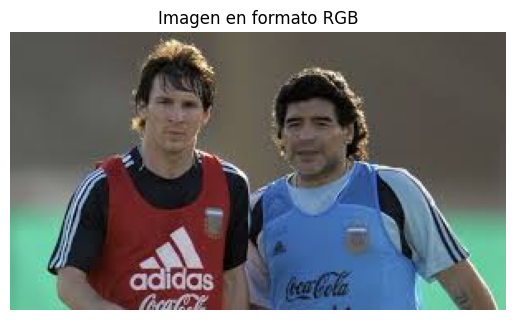

In [ ]:
imagen_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Conversión a RGB

# Mostrar la imagen con Matplotlib
plt.imshow(imagen_rgb)
plt.axis('off')
plt.title('Imagen en formato RGB')
plt.show()


### 1.2 **Ejercicio 2:** Convertir la Imagen a Escala de Grises

El detector Haar necesita la imagen en escala de grises.

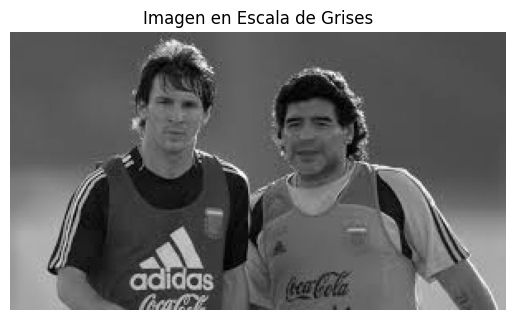

In [ ]:
# Convertir la imagen original BGR a escala de grises
imagen_gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Mostrar la imagen en escala de grises
plt.imshow(imagen_gris, cmap='gray')
plt.axis('off')
plt.title('Imagen en Escala de Grises')
plt.show()


### 1.3 **Ejercicio 3:** Cargar Clasificador y Detectar Rostros

Cargamos el archivo `.xml` y usamos el método `detectMultiScale` sobre la imagen gris. Este método busca caras en diferentes tamaños y devuelve una lista de rectángulos `(x, y, ancho, alto)` por cada cara encontrada.

Se detectaron 2 rostro(s).


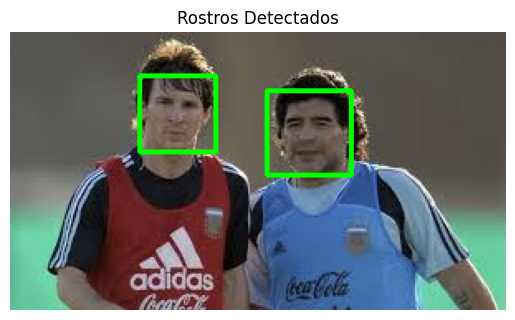

In [ ]:
# Cargar el clasificador Haar de detección de rostros
detector_rostros = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Detectar rostros en la imagen en escala de grises
rostros = detector_rostros.detectMultiScale(
    imagen_gris,
    scaleFactor=1.1,     # Reduce el tamaño de la imagen en cada escala
    minNeighbors=5,      # Cuántos vecinos necesita un rectángulo para ser aceptado como rostro
    minSize=(30, 30)     # Tamaño mínimo que puede tener un rostro
)

# Mostrar cantidad de rostros detectados
print(f"Se detectaron {len(rostros)} rostro(s).")

# Dibujar los rostros detectados sobre una copia de la imagen original
imagen_con_rostros = image.copy()
for (x, y, w, h) in rostros:
    cv2.rectangle(imagen_con_rostros, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Mostrar la imagen con los rostros detectados
imagen_rgb = cv2.cvtColor(imagen_con_rostros, cv2.COLOR_BGR2RGB)
plt.imshow(imagen_rgb)
plt.axis('off')
plt.title('Rostros Detectados')
plt.show()


### 1.4 **Ejercicio 4:** Dibujar Bounding Boxes y Nombres

Visualizamos los resultados dibujando rectángulos y nombres sobre la imagen RGB.

**Tarea:** Dibuja la bounding box de Darín en rojo y la de Pauls en verde. Añade sus nombres encima.
*Asumiremos que `faces[0]` es Pauls y `faces[1]` es Darín según el orden de detección típico (puede variar).*

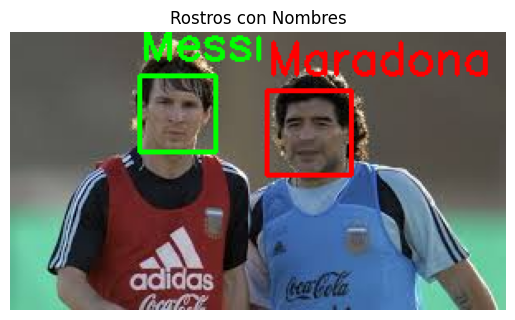

In [ ]:
# Crear una copia de la imagen original
imagen_con_nombres = image.copy()

# Dibujar bounding boxes y nombres
# rostros[0] es Messi, y rostros[1] es Maradona
if len(rostros) >= 2:
    # Messi (verde)
    x, y, w, h = rostros[0]
    cv2.rectangle(imagen_con_nombres, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(imagen_con_nombres, 'Messi', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Maradona (rojo)
    x, y, w, h = rostros[1]
    cv2.rectangle(imagen_con_nombres, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(imagen_con_nombres, 'Maradona', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
else:
    print("No se detectaron suficientes rostros.")

# Convertir a RGB para mostrar con Matplotlib
imagen_rgb = cv2.cvtColor(imagen_con_nombres, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con las cajas y nombres
plt.imshow(imagen_rgb)
plt.axis('off')
plt.title('Rostros con Nombres')
plt.show()


## Sección 2: Detección de Landmarks Faciales con LBF

**Concepto:** Una vez ubicada una cara (con su bounding box), podemos usar un detector de landmarks para encontrar puntos precisos en ella. El método LBF (Local Binary Features) usa un modelo (`lbfmodel.yaml`) entrenado para localizar 68 puntos estándar en el rostro. Necesita la imagen en escala de grises y las bounding boxes como entrada.

### 2.1 Cargar Modelo y Detectar Landmarks

In [ ]:
# Cargar el detector de landmarks y aplicarlo

if imagen_gris is not None and len(rostros) > 0:
  # Creamos el detector
  landmark_detector = cv2.face.createFacemarkLBF()
  # Cargamos el modelo
  try:
    landmark_detector.loadModel("lbfmodel.yaml")
    print("Modelo LBF cargado.")

    # Aplicamos el detector ('fit')
    # Recibe la imagen GRIS y las bounding boxes 'faces'
    ok, all_landmarks = landmark_detector.fit(imagen_gris, rostros)

    if ok:
      print(f"Se detectaron landmarks para {len(all_landmarks)} rostro(s).")
      # all_landmarks es una lista, cada elemento es un array de landmarks para una cara
    else:
      print("Error durante la detección de landmarks con .fit()")
      all_landmarks = None

  except cv2.error as e:
    print(f"Error cargando o usando el modelo LBF: {e}")
    print("Asegúrate que 'lbfmodel.yaml' se descargó correctamente.")
    all_landmarks = None
else:
  print("Se requiere la imagen gris y las caras detectadas ('rostros').")
  all_landmarks = None

Modelo LBF cargado.
Se detectaron landmarks para 2 rostro(s).


### 2.2 Procesar y Visualizar Landmarks (Messi)

Los landmarks vienen en un formato específico (array 3D, tipo float). Los procesamos para obtener un array 2D de enteros `(x, y)` para cada uno de los 68 puntos del primer rostro (Pauls) y los dibujamos.

Landmarks Messi procesados. Forma: (68, 2)

Dibujando landmarks de Messi (verde):


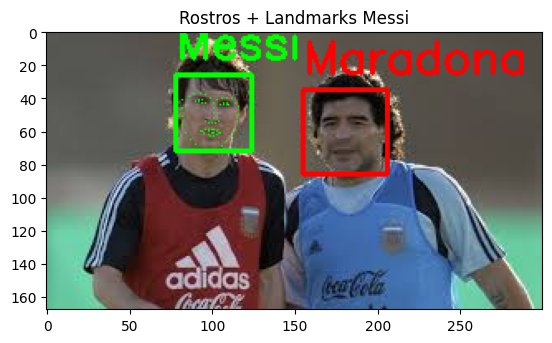

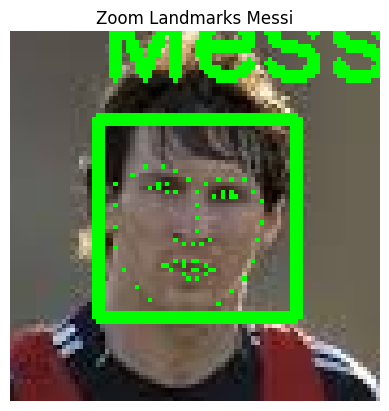

In [ ]:
# Procesar y dibujar landmarks de Messi

if all_landmarks is not None and len(all_landmarks) >= 1:
  # Landmarks del primer rostro (indice 0)
  landmarks_messi = all_landmarks[0]
  # Quitar dimensión extra y convertir a enteros
  landmarks_messi = landmarks_messi[0].astype(int)
  print("Landmarks Messi procesados. Forma:", landmarks_messi.shape) # Debe ser (68, 2)

  # Dibujar sobre la imagen 'img_rgb' (que ya tiene boxes/nombres)
  print("\nDibujando landmarks de Messi (verde):")
  for x, y in landmarks_messi:
      cv2.circle(imagen_rgb, (x, y), 0, (0, 255, 0), 1) # Radio 0, grosor 1 para punto pequeño
  plt.imshow(imagen_rgb)
  plt.title("Rostros + Landmarks Messi")

 # Obtener coordenadas del bounding box de Messi (rostros[0])
x, y, w, h = rostros[0]

# Ajustar un margen para que el zoom no quede tan justo
margen = 20
y1 = max(y - margen, 0)
y2 = y + h + margen
x1 = max(x - margen, 0)
x2 = x + w + margen

# Mostrar zoom sobre Messi
plt.figure()
plt.imshow(imagen_rgb[y1:y2, x1:x2])
plt.title("Zoom Landmarks Messi")
plt.axis('off')
plt.show()



### 2.3 **Ejercicio 5:** Procesar y Dibujar Landmarks (Maradona)

**Tarea:** Haz lo mismo que en la celda anterior pero para el segundo rostro (Darín, índice 1) y dibuja sus landmarks en rojo sobre la *misma* imagen `img_rgb`.

Landmarks Darín procesados. Forma: (68, 2)

Dibujando landmarks de Maradona (rojo):


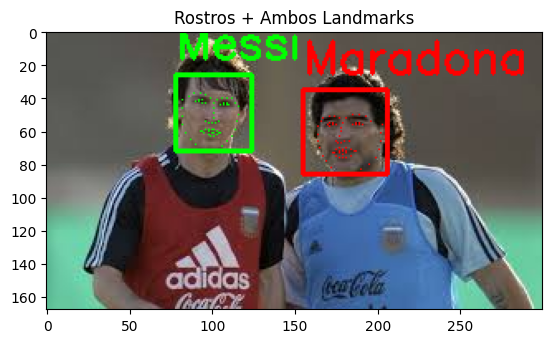

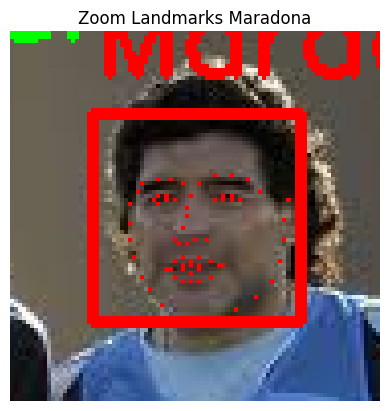

In [ ]:
# Solución Ejercicio 5 (Procesar y dibujar landmarks Maradona)

if all_landmarks is not None and len(all_landmarks) >= 2:
  # Procesar landmarks Maradona (indice 1)
  landmarks_Maradona = all_landmarks[1]
  landmarks_Maradona = landmarks_Maradona[0].astype(int)
  print("Landmarks Darín procesados. Forma:", landmarks_Maradona.shape)

  # Dibujar sobre la imagen 'imagen_rgb' existente
  print("\nDibujando landmarks de Maradona (rojo):")
  for x, y in landmarks_Maradona:
      cv2.circle(imagen_rgb, (x, y), 0, (255, 0, 0), 1)
  plt.imshow(imagen_rgb)
  plt.title("Rostros + Ambos Landmarks")

  # Obtener coordenadas del bounding box de Maradona (rostros[1])
x, y, w, h = rostros[1]

# Ajustar un margen para que el zoom no quede tan justo
margen = 20
y1 = max(y - margen, 0)
y2 = y + h + margen
x1 = max(x - margen, 0)
x2 = x + w + margen

# Mostrar zoom sobre Maradona
plt.figure()
plt.imshow(imagen_rgb[y1:y2, x1:x2])
plt.title("Zoom Landmarks Maradona")
plt.axis('off')
plt.show()



## Sección 3: Selección y Aplicación de Landmarks

Conociendo el índice de cada landmark (ver imagen de la malla), podemos seleccionar y usar solo los puntos que nos interesan para tareas específicas.

### 3.1 **Ejercicio 6:** Dibujar Ojos y Boca (Messi)

**Tarea:**
1.  Define listas con los índices correspondientes a los ojos y la boca.
2.  Crea una **copia limpia** de la imagen RGB original (`img_con_partes = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`).
3.  Itera sobre `landmarks_messi`.
4.  Dibuja solo los puntos de ojos y boca sobre `img_con_partes` usando colores distintos (Magenta, Azul, Cian).
5.  Muestra un zoom en Pauls de la imagen resultante.

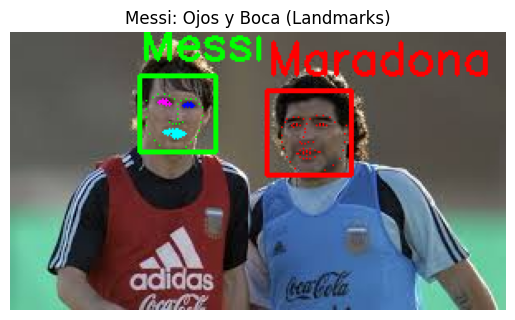

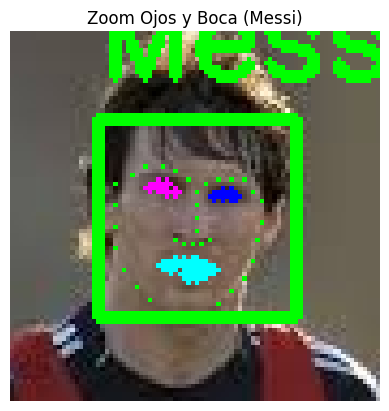

In [ ]:
# Definir los índices de los landmarks para ojos y boca
ojo_izq_idx = list(range(36, 42))
ojo_der_idx = list(range(42, 48))
boca_idx = list(range(48, 68))

# Crear copia limpia de la imagen RGB original
img_con_partes = imagen_rgb.copy()

# Dibujar los landmarks correspondientes
for i, (x, y) in enumerate(landmarks_messi):
    if i in ojo_izq_idx:
        cv2.circle(img_con_partes, (x, y), 1, (255, 0, 255), -1)  # Magenta
    elif i in ojo_der_idx:
        cv2.circle(img_con_partes, (x, y), 1, (0, 0, 255), -1)    # Azul
    elif i in boca_idx:
        cv2.circle(img_con_partes, (x, y), 1, (0, 255, 255), -1)  # Cian

# Mostrar imagen completa con ojos y boca destacados
plt.imshow(img_con_partes)
plt.title("Messi: Ojos y Boca (Landmarks)")
plt.axis('off')
plt.show()

# Mostrar zoom al rostro de Messi usando el bounding box (rostros[0])
x, y, w, h = rostros[0]
margen = 20
plt.figure()
plt.imshow(img_con_partes[y - margen:y + h + margen, x - margen:x + w + margen])
plt.title("Zoom Ojos y Boca (Messi)")
plt.axis('off')
plt.show()


## Sección 4: Conclusión y Próximos Pasos

En este laboratorio, hemos integrado la detección de rostros con la localización de landmarks faciales usando OpenCV. Vimos cómo preparar la imagen, aplicar los detectores y visualizar los resultados, incluyendo la selección de puntos específicos.

Estos landmarks son bloques de construcción para aplicaciones más avanzadas como:
*   **Detección de Somnolencia/Bostezos:** Calculando Eye Aspect Ratio (EAR) y Mouth Aspect Ratio (MAR).
*   **Análisis de Expresiones Faciales.**
*   **Realidad Aumentada.**

**Ideas para continuar:**
*   Investiga y calcula EAR y MAR para los rostros detectados.
*   Aplica este flujo de trabajo a otras imágenes o a los fotogramas de un video.